**Write the names of all group members (max. 5 members)**:
- FirstName1, LastName1
- FirstName2, LastName2
- FirstName3, LastName3
- FirstName4, LastName4
- FirstName5, LastName5

When submitting your work, please follow closely the template below.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt



# Exercise 1

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.


The general Black-Scholes SDE is given by

$$dS_t = rS_t dt + \sigma S_t dW_t,\quad S_0=s_0\in\mathbb{R}_+ $$

Itô's lemma states that any general (well defined) SDE on the form

$$dX_t = \mu(t,X_t) dt +  \sigma(t,X_t) dW_t$$

can be solved with 

$$ df(t,X_t) = \left(\frac{\partial f}{\partial t}+\mu(t,X_t) \frac{\partial f}{\partial x}+\frac{\sigma^2(t,X_t)}{2} \frac{\partial^2 f}{\partial x^2}\right)dt +\sigma(t,X_t)\frac{\partial f}{\partial x} dW_t$$

let $f(t,X_t) = \ln(X_t)$

$$d(\ln(X_t)) = \left(\mu(t,X_t) \frac{1}{X_t}-\frac{\sigma^2(t,X_t)}{2} \frac{1}{X_t^2}\right)dt +\sigma(t,X_t)\frac{1}{X_t} dW_t$$

and integrate over $[0,t]$ w.r.t. s:

$$\int^{t}_{0} d(\ln(X_s)) = \displaystyle \int^{t}_{0} \left(\mu(s,X_s) \frac{1}{X_s}-\frac{\sigma^2(s,X_s)}{2} \frac{1}{X_t^2}\right)ds + \displaystyle \int^{t}_{0}\sigma(s,X_s)\frac{1}{X_s} dW_s$$

$$ \Leftrightarrow  \ln\left(\frac{X_t}{X_0}\right) = \left(\mu(t,X_t) \frac{1}{X_t}-\frac{\sigma^2(t,X_t)}{2} \frac{1}{X_t^2}\right)t + \sigma(t,X_t)\frac{1}{X_t} W_t $$

Let $\mu(t,X_t) \coloneqq r S_t$, $\sigma(t,X_t) \coloneqq \sigma S_t$ and $X_t \coloneqq S_t$ (as in the formula at top)

$$ \Rightarrow  \ln\left(\frac{S_t}{S_0}\right) = \left(rS_t-\frac{\sigma^2}{2}\right)t + \sigma W_t  \Leftrightarrow S_t = S_0 \exp\left(\left(rS_t-\frac{\sigma^2}{2}\right)t + \sigma W_t\right)$$

And if we assume $r = 0$ then 

$$ S_t = S_0 \exp\left(\sigma W_t-\frac{\sigma^2 t}{2} \right) \quad \textbf{q.e.d}$$





### Question 1.b - Generate dataset

In [19]:
torch.manual_seed(10)

N = 30
s0 = 1
m = 10**5 # training set size
n = 10**4 # test set size
sigma = 0.5
T = 30/365

Z = torch.randn(m+n,N+1)
a = - (sigma**2)/2 * (T/N) * torch.ones(N+1)

S = torch.zeros(m+n,N+1)
S[:,0] = torch.ones_like(S[:,0])
for t in range(N):
    b = sigma*(T/N)**(0.5) * Z[:,t+1]
    S[:,t+1] = S[:,t]*torch.exp(a[t]+b)

# Generate the training set
S_train = S[:m,:]
# Generate the test set
S_test = S[m:,:]

# plt.hist(S_train.mean(dim=1),density=True)
# plt.hist(S_test.mean(dim=1),density=True)
# plt.show()
# plt.hist(S_train.std(dim=1),density=True)
# plt.hist(S_test.std(dim=1),density=True)
# plt.show()

### Question 1.c - Model implementation

In [20]:
# Implement the deep hedging model
nh1 = 32
nh2 = 32

H = [] 
for t in range(N):
    network = nn.Sequential(
    nn.Linear(1, nh1),
    nn.ReLU(), 
    nn.Linear(nh1, nh2), 
    nn.ReLU(), 
    nn.Linear(nh2, 1))

    H.append(network)

# You may use and edit the code shown in demo.ipynb

### Question 1.d - Model training

In [21]:
K = 1
S0 = 1
# Implement the payoff function of a call option
g = lambda s,k: torch.relu(s-k)
# Implement a function that returns the Black-Scholes price of a call option with given strike and maturity
def C(S_t,t=0,r=0,K=1,T=30/365,sigma=0.5):
    tt = torch.tensor(T-t)
    tt_sq = torch.sqrt(tt)
    d_p = 1/(sigma*tt_sq) * (torch.log(S_t/K)+(r+sigma**2/2)*tt)
    d_m = d_p - sigma*tt_sq
    Phi = torch.distributions.Normal(0,1)

    return Phi.cdf(d_p)*S_t-Phi.cdf(d_m)*K*torch.exp(-r*tt)

y_true = g(S[:,-1],K)
y_train = y_true[:m]
y_test = y_true[m:]

n_epochs = 100
batch_size = 1000
# Train the model
params = []
for t in range(N):
    params += list(H[t].parameters())
opt = torch.optim.Adam(params,lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[75], gamma=0.1)

C0 = C(torch.tensor(S0))
L = []
training_loop = tqdm(range(n_epochs)) 
for epoch in training_loop:
    epoch_loss = 0
    indices = torch.randperm(m)
    for i in range(0, m, batch_size):
        opt.zero_grad()
        batch_idx = indices[i:i+batch_size]
        S_batch = S_train[batch_idx]
        y_batch = y_train[batch_idx]
        hedge_sum = 0
        for t in range(N):
            h_t = H[t](S_batch[:,t].unsqueeze(1)) # ([b] --> [b,1])
            dS_t = (S_batch[:,t+1]-S_batch[:,t]).unsqueeze(1) # [b] --> [b,1]
            hedge_sum += (h_t * dS_t).squeeze(1) # [b,1] --> [b]

        loss = ((y_batch - C0 - hedge_sum)**2).mean()
        loss.backward()
        opt.step()
        
        epoch_loss += loss.item()
    training_loop.set_postfix(loss = epoch_loss)

    L.append(epoch_loss)



  0%|          | 0/100 [00:00<?, ?it/s]

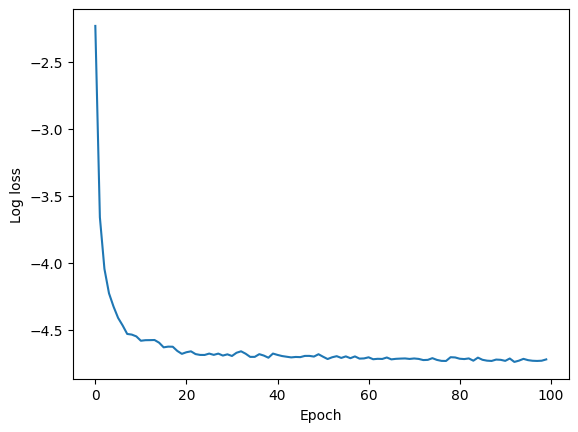

In [22]:
plt.plot(torch.log(torch.tensor(L)))
plt.ylabel("Log loss")
plt.xlabel("Epoch")
plt.show()

### Question 1.e - Model evaluation

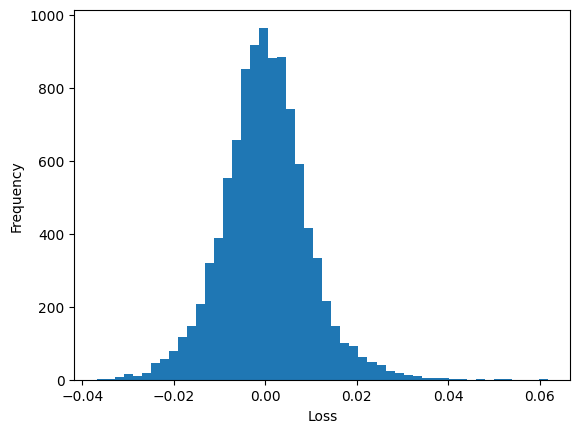

Mean = 5.543e-05
(Sample) Standard Deviation = 9.424e-03


In [ ]:
# Evaluate the hedging losses on the test set
hedge_sum_test = 0
for t in range(N):
    h_t = H[t](S_test[:,t].unsqueeze(1)) # ([b] --> [b,1])
    dS_t = (S_test[:,t+1]-S_test[:,t]).unsqueeze(1) # [b] --> [b,1]
    hedge_sum_test += ((h_t * dS_t).squeeze(1)) # [b,1] --> [b]

loss_test = (y_test - C0 - hedge_sum_test).detach().numpy()

# Plot a histogram of the hedging losses and print mean and standard deviation
plt.hist(loss_test,bins=50)
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()

print(f"Mean = {loss_test.mean():.3e}\n(Sample) Standard Deviation = {loss_test.std(ddof=1):.3e}")

### Question 1.f(i) - Compute analytical solution

Show a **step-by-step** derivation of the analytical hedging strategy:

\begin{align*}
H^{\text{BS}}_t(s) & = \frac{\partial C(s, t)}{\partial s} \\
& = \frac{\partial}{\partial s} \left[ s\Phi(d_+)-K\Phi(d_-)e^{-r(T-t)} \right]  \\
& = \Phi(d_+)+s\partial_s(\Phi(d_+)) - K\partial_s(\Phi(d_-))e^{-r(T-t)} \\
& = \Phi(d_+)+s\left(\frac{s}{\sigma\sqrt{T-t}}\right)\Phi'(d_+) - K\left(\frac{1}{s\sigma\sqrt{T-t}}\right)\Phi'(d_-)e^{-r(T-t)} \\
& = \Phi(d_+)+\frac{1}{\sigma\sqrt{T-t}\sqrt{2\pi}}\exp(-(d_+)^2/2)-\frac{K}{s\sigma\sqrt{T-t}\sqrt{2\pi}}\exp(-(d_-)^2/2)e^{-r(T-t)} \\
& = \Phi(d_+)+\frac{1}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(\exp\left(-\frac{(d_+)^2}{2}\right)-\frac{Ke^{-r(T-t)}}{s} \exp\left(-\frac{(d_-)^2}{2}\right)\right) \\
& = \Phi(d_+)+\frac{1}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(\exp\left(-\frac{(d_+)^2}{2}\right)-\frac{Ke^{-r(T-t)}}{s} \exp\left(-\frac{(d_+-\sigma\sqrt{T-t})^2}{2}\right)\right) \\
& = \Phi(d_+) +\frac{1}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(\exp\left(\frac{-d^2_+}{2}\right)-\frac{K e^{-r(T-t)}}{s}\exp\left(\frac{-d_+^2+2d_+\sigma\sqrt{T-t}-\sigma^2({T-t})}{2}\right)\right) \\
& = \Phi(d_+)+\frac{\exp\left(\frac{-d^2_+}{2}\right)}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(1-\frac{K e^{-r(T-t)}}{s}\exp\left(\frac{2d_+\sigma\sqrt{T-t}-\sigma^2({T-t})}{2}\right)\right) \\
& = \Phi(d_+)+\frac{\exp\left(\frac{-d^2_+}{2}\right)}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(1-\frac{K e^{-r(T-t)}}{s}\exp\left(\frac{2\left(\ln(s/K)+\left(r+\frac{\sigma^2}{2}(T-t)\right)\right)-\sigma^2({T-t})}{2}\right)\right) \\
& = \Phi(d_+)+\frac{\exp\left(\frac{-d^2_+}{2}\right)}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(1-\frac{K e^{-r(T-t)}}{s}\exp\left(\frac{2\left(\ln(s/K)+\left(r(T-t)\right)\right)}{2}\right)\right) \\
& = \Phi(d_+)+\frac{\exp\left(\frac{-d^2_+}{2}\right)}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(1-\frac{K}{s}\exp\left(\ln(s/K)\right)\right) \\
& = \Phi(d_+)+\frac{\exp\left(\frac{-d^2_+}{2}\right)}{\sqrt{2\pi}\sigma\sqrt{T-t}}\left(1-1\right) \\
& = \Phi(d_+) \\
\end{align*}

No points for solutions without explicit derivation.

$$

$$

### Question 1.f(ii) - Losses comparison with analytical solution

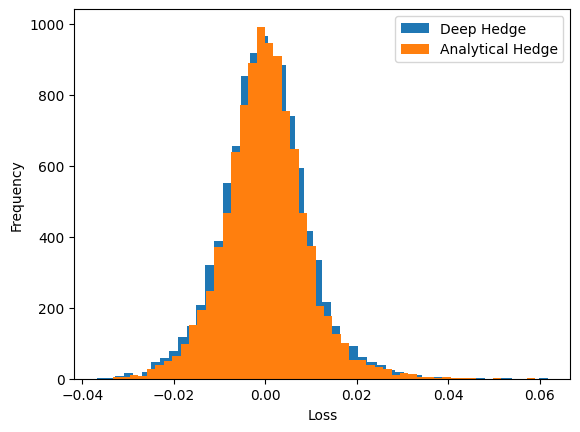

## Deep Hedge  
	Mean = 5.543e-05
	(Sample) Standard Deviation = 9.424e-03
## Analytical Hedge  
	Mean = 5.119e-05
	(Sample) Standard Deviation = 8.952e-03


In [39]:
# Implement the formula you found
def H_bs(S_t,t=0,r=0,K=1,T=30/365,sigma=0.5):
    tt = torch.tensor(T-t)
    tt_sq = torch.sqrt(tt)
    d_p = 1/(sigma*tt_sq) * (torch.log(S_t/K)+(r+sigma**2/2)*tt)
    Phi = torch.distributions.Normal(0,1)
    return  Phi.cdf(d_p)

# Evaluate the losses of the analytical hedging strategies on the test set
hedge_bs_sum_test = 0
dt = T / N

for t in range(N):
    tau_t = t * dt
    h_bs_t = H_bs(S_test[:,t].unsqueeze(1),t=tau_t) # ([b] --> [b,1])
    dS_bs_t = (S_test[:,t+1]-S_test[:,t]).unsqueeze(1) # [b] --> [b,1]
    hedge_bs_sum_test += ((h_bs_t * dS_bs_t).squeeze(1)) # [b,1] --> [b]

loss_bs_test = (y_test - C0 - hedge_bs_sum_test).detach().numpy()
# Plot a histograms of the hedging losses (analytical and deep hedging) and print means and standard deviations
plt.hist(loss_test,bins=50,label="Deep Hedge")
plt.hist(loss_bs_test,bins=50,label="Analytical Hedge")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print("## Deep Hedge  ")
print(f"\tMean = {loss_test.mean():.3e}\n\t(Sample) Standard Deviation = {loss_test.std(ddof=1):.3e}")
print("## Analytical Hedge  ")
print(f"\tMean = {loss_bs_test.mean():.3e}\n\t(Sample) Standard Deviation = {loss_bs_test.std(ddof=1):.3e}")

How does your deep hedging model compare with the analytical solution? If it's worse, you must improve its performance. A few questions for you to consider...

Have you trained your deep hedging model well?
- Are the losses centered on zero? ($10^{-5} \approx 0$)
- Is their standard deviation comparable with that of the analytical solution?

How can you improve performance?
- train for more epochs
- try a different learning rate
- change the networks' architectures (first try more hidden neurons, then try more hidden layers)
- try different batch sizes
- use a learning rate scheduler (see https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- try a different activation function (e.g. $\tanh$)
- implement regularization (use the `weight_decay` argument in the optimizer)
- implement batch-normalization (see https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- experiment with different optimizers
- ask in the forum

#### Notes on the approach
As observed the loss of the deep hedging strategy is rather close the one obtained via analytical solution, nevertheless one could try to minimized it further (while staying clear of overfitting ofcourse).

Suggestions:

Since the networks $H_{t_j}$ are relatively shallow (and do not necessarily need to be any deeper) one could quickly study the them with the Neural Tangent Kernel ([NTK](https://arxiv.org/abs/1806.07572)), derive the "NTK"-matrix which will take no time (if the network is shallow), find eigenvalues and approximate the learning rate (such that the system/network stays stable throughout training). Note that we do not implement this in this project, the computations are a bit delegate. (Notably one of the group members wrote a Python and Julia package to explicitly study networks within this frame).

One needs to be careful thought since there is a set of networks, which brings us to the next suggestion, which is, training a single network that takes care of all time steps hence takes time in as input and the network becomes a mapping $H_t : \mathbb{R}^2 \to \mathbb{R}$.

### Question 1.g - Learned strategy comparison with analytical solution

In [8]:
# Plot both the deep hedging strategies and the analytical hedging strategies

- For what times $t_j$ are the two functions most similar? 
- Why?

# Exercise 2

### Question 2.a - Generate dataset

In [9]:
# Write function to sample V
# Write function to sample S

# Generate the training set
# Generate the test set

### Question 2.b - Model implementation

In [10]:
# Implement the deep hedging model for a generic alpha

### Question 2.c - Model training

In [11]:
# Train two deep hedging models (for alpha=0.5 and alpha=0.99) for the call option

### Question 2.d - Price comparison

In [12]:
# Print the prices p for alpha=0.5 and alpha=0.99
# Which one is higher? Why? 

### Question 2.e - Price comparison

In [13]:
# Plot a histograms of the hedging losses (for alpha=0.5 and alpha=0.99) and print means and standard deviations